In [1]:
import xarray as xr
import numpy as np
import xarray as xr
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd


In [ ]:
import geopandas as gpd
from shapely.geometry import box
from cartopy.io.shapereader import natural_earth
from scipy.stats import shapiro, ttest_ind
import pycountry

# ─── SETTINGS ─────────────────────────────────────────────────────────
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power"
models    = [
    "ACCESS-CM2","CanESM5","CMCC-CM2-SR5","CMCC-ESM2",
    "HadGEM3-GC31-LL","HadGEM3-GC31-MM","MRI-ESM2-0"
]
periods   = {"BOC":"historical","EOC":"ssp585"}
seasons   = ["Winter","Spring","Summer","Autumn"]

# helper: ISO3→ISO2
def iso3_to_iso2(iso3):
    if iso3=="KOS": return "XK"
    if iso3=="MKD": return "MK"
    c = pycountry.countries.get(alpha_3=iso3)
    return c.alpha_2 if c else None

# load country shapes
shp     = natural_earth('110m','cultural','admin_0_countries')
world   = gpd.read_file(shp).set_crs("EPSG:4326")
europe  = world[
    (world.CONTINENT=="Europe") | (world.ADM0_A3.isin(["TUR","RKS"]))
][["ADM0_A3","geometry"]].rename(columns={"ADM0_A3":"iso_a3"})

# container for results
results = []

for model in models:
    # find the two CSVs
    paths = {}
    for code,sub in periods.items():
        p = os.path.join(power_dir, f"{model}_1x1grid", sub,
                         f"solar_drought_events_{code}.csv")
        if os.path.exists(p): paths[code]=p
    if set(paths)!=set(periods):
        print(f"⚠️ skipping {model}, missing CSV")
        continue

    # read both
    df_boc = pd.read_csv(paths["BOC"])
    df_eoc = pd.read_csv(paths["EOC"])

    # build lat/lon→geometry grid once
    lats = np.sort(np.unique(np.r_[df_boc.lat, df_eoc.lat]))
    lons = np.sort(np.unique(np.r_[df_boc.lon, df_eoc.lon]))
    dlat, dlon = np.median(np.diff(lats)), np.median(np.diff(lons))

    cells = []
    for lat in lats:
        for lon in lons:
            cells.append({
                "lat":lat, "lon":lon,
                "geometry": box(lon-dlon/2,lat-dlat/2,
                                lon+dlon/2,lat+dlat/2)
            })
    cells_gdf = gpd.GeoDataFrame(cells, crs="EPSG:4326")
    cells_eq  = cells_gdf.to_crs("EPSG:3035")
    eur_eq    = europe.to_crs("EPSG:3035")
    inter     = gpd.overlay(cells_eq, eur_eq, how="intersection")
    inter["area"] = inter.geometry.area
    idx       = inter.groupby(["lat","lon"])["area"].idxmax()
    mapping   = inter.loc[idx, ["lat","lon","iso_a3"]]
    cell2ctry = {(r.lat,r.lon):r.iso_a3 for _,r in mapping.iterrows()}

    # loop seasons
    for season in seasons:
        # build per‐period country×year median‐duration series
        med_ts = {}
        for code, df in [("BOC",df_boc),("EOC",df_eoc)]:
            dfx = df[df.season==season].copy()

            # compute per‐cell×year p50 event duration
            # group durations by (lat,lon,year), then take median
            cell_year = (
                dfx.groupby(["lat","lon","year"])["duration"]
                   .median()
                   .reset_index(name="p50_duration")
            )
            # map to iso3
            cell_year["iso_a3"] = cell_year.apply(
                lambda r: cell2ctry.get((r.lat,r.lon), np.nan),
                axis=1
            )
            cell_year = cell_year.dropna(subset=["iso_a3"])
            # aggregate to country×year by averaging cell medians
            cty = (
                cell_year.groupby(["iso_a3","year"])["p50_duration"]
                         .mean()
                         .reset_index(name="p50_duration")
            )
            med_ts[code] = cty

        # now test each country
        boc_ = med_ts["BOC"]
        eoc_ = med_ts["EOC"]
        common = set(boc_.iso_a3)&set(eoc_.iso_a3)
        for iso in common:
            x = boc_.loc[boc_.iso_a3==iso,"p50_duration"].values
            y = eoc_.loc[eoc_.iso_a3==iso,"p50_duration"].values
            # need at least 3 yrs of data
            if len(x)<3 or len(y)<3: continue
            # skip flat series
            if np.allclose(x,x[0]) or np.allclose(y,y[0]):
                p1=p2=pt=np.nan
                sig=False
            else:
                p1 = shapiro(x).pvalue
                p2 = shapiro(y).pvalue
                _, pt = ttest_ind(x,y, equal_var=False)
                sig = pt<0.05

            results.append({
                "model":        model,
                "country":      iso,
                "season":       season,
                "median_boc":   np.median(x),
                "median_eoc":   np.median(y),
                "shapiro_boc_p":p1,
                "shapiro_eoc_p":p2,
                "ttest_p":      pt,
                "significant":  sig
            })

# save
out = pd.DataFrame(results)
out.to_csv(
    os.path.join(power_dir, "country_seasonal_p50_tests.csv"),
    index=False
)
print("✅ p50 seasonal tests saved.")


✅ p50 seasonal tests saved.


In [3]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from cartopy.io.shapereader import natural_earth
from scipy.stats import shapiro, ttest_ind
import pycountry

# ─── SETTINGS ─────────────────────────────────────────────────────────
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power"
models    = [
    "ACCESS-CM2","CanESM5","CMCC-CM2-SR5","CMCC-ESM2",
    "HadGEM3-GC31-LL","HadGEM3-GC31-MM","MRI-ESM2-0"
]
periods   = {"BOC":"historical","EOC":"ssp585"}

# helper: ISO3→ISO2 (for final mapping if needed)
def iso3_to_iso2(iso3):
    if iso3=="KOS": return "XK"
    if iso3=="MKD": return "MK"
    c = pycountry.countries.get(alpha_3=iso3)
    return c.alpha_2 if c else None

# 1) Load country geometries for Europe + Turkey + Kosovo
shp     = natural_earth('110m','cultural','admin_0_countries')
world   = gpd.read_file(shp).set_crs("EPSG:4326")
europe  = world[
    (world.CONTINENT=="Europe") | (world.ADM0_A3.isin(["TUR","RKS"]))
][["ADM0_A3","geometry"]].rename(columns={"ADM0_A3":"iso_a3"})

results = []

for model in models:
    # 2) Locate both event‐list CSVs
    paths = {}
    for code,sub in periods.items():
        p = os.path.join(power_dir, f"{model}_1x1grid", sub,
                         f"solar_drought_events_{code}.csv")
        if os.path.exists(p):
            paths[code] = p
    if set(paths) != set(periods):
        print(f"⚠️ skipping {model}, missing CSVs")
        continue

    df_boc = pd.read_csv(paths["BOC"])
    df_eoc = pd.read_csv(paths["EOC"])

    # 3) Build cell→country mapping once
    lats = np.sort(np.unique(np.r_[df_boc.lat, df_eoc.lat]))
    lons = np.sort(np.unique(np.r_[df_boc.lon, df_eoc.lon]))
    dlat, dlon = np.median(np.diff(lats)), np.median(np.diff(lons))

    cells = []
    for lat in lats:
        for lon in lons:
            cells.append({
                "lat":lat, "lon":lon,
                "geometry": box(lon-dlon/2,lat-dlat/2,
                                lon+dlon/2,lat+dlat/2)
            })
    cells_gdf = gpd.GeoDataFrame(cells, crs="EPSG:4326")
    cells_eq  = cells_gdf.to_crs("EPSG:3035")
    eur_eq    = europe.to_crs("EPSG:3035")
    inter     = gpd.overlay(cells_eq, eur_eq, how="intersection")
    inter["area"] = inter.geometry.area
    idx       = inter.groupby(["lat","lon"])["area"].idxmax()
    mapping   = inter.loc[idx, ["lat","lon","iso_a3"]]
    cell2ctry = {(r.lat,r.lon):r.iso_a3 for _,r in mapping.iterrows()}

    # 4) For each period, build a country×year time series of p50 durations
    ts = {}
    for code, df in [("BOC",df_boc),("EOC",df_eoc)]:
        # group all events in a cell‐year → median duration
        cy = (
            df.groupby(["lat","lon","year"])["duration"]
              .median()
              .reset_index(name="p50_duration")
        )
        # map to iso3
        cy["iso_a3"] = cy.apply(
            lambda r: cell2ctry.get((r.lat,r.lon), np.nan),
            axis=1
        )
        cy = cy.dropna(subset=["iso_a3"])
        # average these medians across cells to get country×year
        cty = (
            cy.groupby(["iso_a3","year"])["p50_duration"]
               .mean()
               .reset_index(name="p50_duration")
        )
        ts[code] = cty

    # 5) Perform Shapiro + Welch t-test for each country
    boc_ = ts["BOC"]
    eoc_ = ts["EOC"]
    common = set(boc_.iso_a3) & set(eoc_.iso_a3)

    for iso in common:
        x = boc_.loc[boc_.iso_a3==iso,"p50_duration"].values
        y = eoc_.loc[eoc_.iso_a3==iso,"p50_duration"].values
        # need >=3 years and non‐flat
        if len(x)<3 or len(y)<3 or np.allclose(x,x[0]) or np.allclose(y,y[0]):
            continue

        p1 = shapiro(x).pvalue
        p2 = shapiro(y).pvalue
        _, pt = ttest_ind(x, y, equal_var=False)
        sig = pt < 0.05

        results.append({
            "model":        model,
            "country":      iso,
            "median_boc":   np.median(x),
            "median_eoc":   np.median(y),
            "shapiro_boc_p":p1,
            "shapiro_eoc_p":p2,
            "ttest_p":      pt,
            "significant":  sig
        })

# 6) Save your annual p50 results
out = pd.DataFrame(results)
out.to_csv(
    os.path.join(power_dir, "country_annual_p50_tests.csv"),
    index=False
)
print("✅ Annual p50 tests saved.")


✅ Annual p50 tests saved.


In [4]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from cartopy.io.shapereader import natural_earth
from scipy.stats import shapiro, ttest_ind
import pycountry

# ─── SETTINGS ─────────────────────────────────────────────────────────
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power"
models    = [
    "ACCESS-CM2","CanESM5","CMCC-CM2-SR5","CMCC-ESM2",
    "HadGEM3-GC31-LL","HadGEM3-GC31-MM","MRI-ESM2-0"
]
periods   = {"BOC":"historical","EOC":"ssp585"}
seasons   = ["Winter","Spring","Summer","Autumn"]

# helper to map ISO3→ISO2 if needed
def iso3_to_iso2(iso3):
    if iso3=="KOS": return "XK"
    if iso3=="MKD": return "MK"
    c = pycountry.countries.get(alpha_3=iso3)
    return c.alpha_2 if c else None

# load Europe+Turkey+Kosovo shapes for cell→country mapping
shp    = natural_earth('110m','cultural','admin_0_countries')
world  = gpd.read_file(shp).set_crs("EPSG:4326")
europe = world[
    (world.CONTINENT=="Europe") | (world.ADM0_A3.isin(["TUR","RKS"]))
][["ADM0_A3","geometry"]].rename(columns={"ADM0_A3":"iso_a3"})

results = []

for model in models:
    # 1) find your two event CSVs
    paths = {}
    for code,sub in periods.items():
        p = os.path.join(power_dir, f"{model}_1x1grid", sub,
                         f"solar_drought_events_{code}.csv")
        if os.path.exists(p): paths[code] = p
    if set(paths)!=set(periods):
        print(f"⚠️ skipping {model}, missing CSVs")
        continue

    df_boc = pd.read_csv(paths["BOC"])
    df_eoc = pd.read_csv(paths["EOC"])

    # 2) build lat/lon → country (iso3) once
    lats = np.sort(np.unique(np.r_[df_boc.lat, df_eoc.lat]))
    lons = np.sort(np.unique(np.r_[df_boc.lon, df_eoc.lon]))
    dlat, dlon = np.median(np.diff(lats)), np.median(np.diff(lons))

    cells = []
    for lat in lats:
        for lon in lons:
            cells.append({
                "lat":lat, "lon":lon,
                "geometry": box(lon-dlon/2, lat-dlat/2,
                                lon+dlon/2, lat+dlat/2)
            })
    cells_gdf = gpd.GeoDataFrame(cells, crs="EPSG:4326")
    cells_eq  = cells_gdf.to_crs("EPSG:3035")
    eur_eq    = europe.to_crs("EPSG:3035")
    inter     = gpd.overlay(cells_eq, eur_eq, how="intersection")
    inter["area"] = inter.geometry.area
    idx       = inter.groupby(["lat","lon"])["area"].idxmax()
    mapping   = inter.loc[idx, ["lat","lon","iso_a3"]]
    cell2ctry = {(r.lat, r.lon): r.iso_a3 for _,r in mapping.iterrows()}

    # 3) loop seasons and compute a country×year p75 series, then test
    for season in seasons:
        # per-period country×year containers
        ts = {}
        for code, df in [("BOC",df_boc), ("EOC",df_eoc)]:
            dfx = df[df.season == season]

            # per-cell×year 75th percentile
            cy = (
                dfx.groupby(["lat","lon","year"])["duration"]
                   .quantile(0.75)
                   .reset_index(name="p75_duration")
            )
            cy["iso_a3"] = cy.apply(
                lambda r: cell2ctry.get((r.lat, r.lon), np.nan),
                axis=1
            )
            cy = cy.dropna(subset=["iso_a3"])

            # average those cell p75s to get country×year
            cty = (
                cy.groupby(["iso_a3","year"])["p75_duration"]
                   .mean()
                   .reset_index(name="p75_duration")
            )
            ts[code] = cty

        # now perform tests
        boc_ = ts["BOC"]
        eoc_ = ts["EOC"]
        common = set(boc_.iso_a3) & set(eoc_.iso_a3)

        for iso in common:
            x = boc_.loc[boc_.iso_a3==iso, "p75_duration"].values
            y = eoc_.loc[eoc_.iso_a3==iso, "p75_duration"].values

            # need enough years and some variance
            if len(x)<3 or len(y)<3 or np.allclose(x, x[0]) or np.allclose(y, y[0]):
                continue

            p1 = shapiro(x).pvalue
            p2 = shapiro(y).pvalue
            _, pt = ttest_ind(x, y, equal_var=False)
            sig = pt < 0.05

            results.append({
                "model":        model,
                "country":      iso,
                "season":       season,
                "p75_boc":      np.quantile(x, 0.75),
                "p75_eoc":      np.quantile(y, 0.75),
                "shapiro_boc_p":p1,
                "shapiro_eoc_p":p2,
                "ttest_p":      pt,
                "significant":  sig
            })

# 4) save to CSV
out = pd.DataFrame(results)
out.to_csv(
    os.path.join(power_dir, "country_seasonal_p75_tests.csv"),
    index=False
)
print("✅ Seasonal p75 tests saved.")


✅ Seasonal p75 tests saved.


In [5]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from cartopy.io.shapereader import natural_earth
from scipy.stats import shapiro, ttest_ind
import pycountry

# ─── SETTINGS ─────────────────────────────────────────────────────────
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power"
models    = [
    "ACCESS-CM2","CanESM5","CMCC-CM2-SR5","CMCC-ESM2",
    "HadGEM3-GC31-LL","HadGEM3-GC31-MM","MRI-ESM2-0"
]
periods   = {"BOC":"historical","EOC":"ssp585"}

# helper to map iso3→iso2 if you need it later
def iso3_to_iso2(iso3):
    if iso3=="KOS": return "XK"
    if iso3=="MKD": return "MK"
    c = pycountry.countries.get(alpha_3=iso3)
    return c.alpha_2 if c else None

# 1) Load country geometries
shp     = natural_earth('110m','cultural','admin_0_countries')
world   = gpd.read_file(shp).set_crs("EPSG:4326")
europe  = world[
    (world.CONTINENT=="Europe") | (world.ADM0_A3.isin(["TUR","RKS"]))
][["ADM0_A3","geometry"]].rename(columns={"ADM0_A3":"iso_a3"})

results = []

for model in models:
    # 2) find your two CSVs
    paths = {}
    for code,sub in periods.items():
        f = os.path.join(power_dir, f"{model}_1x1grid", sub,
                         f"solar_drought_events_{code}.csv")
        if os.path.exists(f):
            paths[code] = f
    if set(paths)!=set(periods):
        print(f"⚠️ skipping {model}, missing data")
        continue

    df_boc = pd.read_csv(paths["BOC"])
    df_eoc = pd.read_csv(paths["EOC"])

    # 3) build the lat/lon → country overlay once
    lats = np.sort(np.unique(np.r_[df_boc.lat, df_eoc.lat]))
    lons = np.sort(np.unique(np.r_[df_boc.lon, df_eoc.lon]))
    dlat, dlon = np.median(np.diff(lats)), np.median(np.diff(lons))

    cells = []
    for lat in lats:
        for lon in lons:
            cells.append({
                "lat":lat, "lon":lon,
                "geometry": box(lon-dlon/2,lat-dlat/2,
                                lon+dlon/2,lat+dlat/2)
            })
    cells_gdf = gpd.GeoDataFrame(cells, crs="EPSG:4326")
    cells_eq  = cells_gdf.to_crs("EPSG:3035")
    eur_eq    = europe.to_crs("EPSG:3035")
    inter     = gpd.overlay(cells_eq, eur_eq, how="intersection")
    inter["area"] = inter.geometry.area
    idx       = inter.groupby(["lat","lon"])["area"].idxmax()
    mapping   = inter.loc[idx, ["lat","lon","iso_a3"]]
    cell2ctry = {(r.lat,r.lon):r.iso_a3 for _,r in mapping.iterrows()}

    # 4) build country×year p75 series
    ts = {}
    for code, df in [("BOC",df_boc), ("EOC",df_eoc)]:
        # per‐cell×year p75
        cy = (
            df.groupby(["lat","lon","year"])["duration"]
              .quantile(0.75)
              .reset_index(name="p75_duration")
        )
        cy["iso_a3"] = cy.apply(
            lambda r: cell2ctry.get((r.lat,r.lon), np.nan),
            axis=1
        )
        cy = cy.dropna(subset=["iso_a3"])
        # country average of p75
        cty = (
            cy.groupby(["iso_a3","year"])["p75_duration"]
               .mean()
               .reset_index(name="p75_duration")
        )
        ts[code] = cty

    # 5) test each country
    boc_ = ts["BOC"]
    eoc_ = ts["EOC"]
    common = set(boc_.iso_a3) & set(eoc_.iso_a3)

    for iso in common:
        x = boc_.loc[boc_.iso_a3==iso,"p75_duration"].values
        y = eoc_.loc[eoc_.iso_a3==iso,"p75_duration"].values
        # require >=3 yrs and non‐flat
        if len(x)<3 or len(y)<3 or np.allclose(x,x[0]) or np.allclose(y,y[0]):
            continue

        p1 = shapiro(x).pvalue
        p2 = shapiro(y).pvalue
        _, pt = ttest_ind(x, y, equal_var=False)
        sig = pt < 0.05

        results.append({
            "model":        model,
            "country":      iso,
            "p75_boc":      np.quantile(x, 0.75),
            "p75_eoc":      np.quantile(y, 0.75),
            "shapiro_boc_p":p1,
            "shapiro_eoc_p":p2,
            "ttest_p":      pt,
            "significant":  sig
        })

# 6) Save annual p75 tests
out = pd.DataFrame(results)
out.to_csv(
    os.path.join(power_dir, "country_annual_p75_tests.csv"),
    index=False
)
print("✅ Annual p75 tests saved.")


✅ Annual p75 tests saved.


In [34]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from cartopy.io.shapereader import natural_earth
from scipy.stats import shapiro, ttest_ind
import pycountry

# ─── SETTINGS ─────────────────────────────────────────────────────────
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power"
models    = [
    "ACCESS-CM2","CanESM5","CMCC-CM2-SR5","CMCC-ESM2",
    "HadGEM3-GC31-LL","HadGEM3-GC31-MM","MRI-ESM2-0"
]
periods   = {"BOC":"historical","EOC":"ssp585"}
seasons   = ["Winter","Spring","Summer","Autumn"]

# helper to convert ISO3→ISO2 (only needed if you later want 2-letter codes)
def iso3_to_iso2(iso3):
    if iso3=="KOS": return "XK"
    if iso3=="MKD": return "MK"
    c = pycountry.countries.get(alpha_3=iso3)
    return c.alpha_2 if c else None

# load country shapes once
shp    = natural_earth('110m','cultural','admin_0_countries')
world  = gpd.read_file(shp).set_crs("EPSG:4326")
europe = world[
    (world.CONTINENT=="Europe") | (world.ADM0_A3.isin(["TUR","RKS"]))
][["ADM0_A3","geometry"]].rename(columns={"ADM0_A3":"iso_a3"})

# container for all p90 results
records = []

for model in models:
    # find the two CSVs (BOC, EOC)
    csvs = {}
    for code, sub in periods.items():
        path = os.path.join(power_dir, f"{model}_1x1grid", sub,
                            f"solar_drought_events_{code}.csv")
        if os.path.exists(path):
            csvs[code] = pd.read_csv(path)
    if set(csvs) != set(periods):
        print(f"⚠️  Missing files for {model}, skipping.")
        continue

    df_boc, df_eoc = csvs["BOC"], csvs["EOC"]

    # build grid‐cell → iso3 mapping
    lats = np.sort(np.unique(np.r_[df_boc.lat, df_eoc.lat]))
    lons = np.sort(np.unique(np.r_[df_boc.lon, df_eoc.lon]))
    dlat, dlon = np.median(np.diff(lats)), np.median(np.diff(lons))

    cells = []
    for lat in lats:
        for lon in lons:
            cells.append({
                "lat": lat, "lon": lon,
                "geometry": box(lon-dlon/2, lat-dlat/2,
                                lon+dlon/2, lat+dlat/2)
            })
    cells_gdf = gpd.GeoDataFrame(cells, crs="EPSG:4326")
    cells_eq  = cells_gdf.to_crs("EPSG:3035")
    eur_eq    = europe.to_crs("EPSG:3035")
    inter     = gpd.overlay(cells_eq, eur_eq, how="intersection")
    inter["area"] = inter.geometry.area
    idx        = inter.groupby(["lat","lon"])["area"].idxmax()
    mapping    = inter.loc[idx, ["lat","lon","iso_a3"]]
    cell2ctry  = {(r.lat, r.lon): r.iso_a3 for _, r in mapping.iterrows()}

    # for each season compute per-country p90 × year and test
    for season in seasons:
        # subselect season
        boc_seas = df_boc[df_boc.season == season]
        eoc_seas = df_eoc[df_eoc.season == season]

        # compute per‐cell×year p90 durations
        def make_country_series(df_seas):
            cy = (
                df_seas
                .groupby(["lat","lon","year"])["duration"]
                .quantile(0.90)
                .reset_index(name="p90_dur")
            )
            cy["iso_a3"] = cy.apply(
                lambda r: cell2ctry.get((r.lat, r.lon), np.nan), axis=1
            )
            cy = cy.dropna(subset=["iso_a3"])
            # average across all cells in the country
            return (
                cy
                .groupby(["iso_a3","year"])["p90_dur"]
                .mean()
                .reset_index()
            )

        boc_cty = make_country_series(boc_seas)
        eoc_cty = make_country_series(eoc_seas)

        # find countries present in both
        common = set(boc_cty.iso_a3) & set(eoc_cty.iso_a3)
        for iso in sorted(common):
            x = boc_cty.loc[boc_cty.iso_a3==iso,"p90_dur"].values
            y = eoc_cty.loc[eoc_cty.iso_a3==iso,"p90_dur"].values
            # need ≥3 years
            if len(x) < 3 or len(y) < 3:
                continue

            # if flat, skip
            if np.allclose(x, x[0]) or np.allclose(y, y[0]):
                p_sh1 = p_sh2 = p_t = np.nan
                sig   = False
            else:
                p_sh1 = shapiro(x).pvalue
                p_sh2 = shapiro(y).pvalue
                _, p_t = ttest_ind(x, y, equal_var=False)
                sig    = p_t < 0.05

            records.append({
                "model":       model,
                "country":     iso,
                "season":      season,
                "median_p90_boc": np.median(x),
                "median_p90_eoc": np.median(y),
                "shapiro_boc_p90": p_sh1,
                "shapiro_eoc_p90": p_sh2,
                "ttest_p90":      p_t,
                "sig_p90":        sig
            })

# save only p90 results
out_df = pd.DataFrame(records)
out_df.to_csv(
    os.path.join(power_dir, "country_seasonal_p90_tests.csv"),
    index=False
)
print("✅ Seasonal p90 results written to country_seasonal_p90_tests.csv")


✅ Seasonal p90 results written to country_seasonal_p90_tests.csv


In [35]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from cartopy.io.shapereader import natural_earth
from scipy.stats import shapiro, ttest_ind
import pycountry

# ─── SETTINGS ─────────────────────────────────────────────────────────
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power"
models    = [
    "ACCESS-CM2","CanESM5","CMCC-CM2-SR5","CMCC-ESM2",
    "HadGEM3-GC31-LL","HadGEM3-GC31-MM","MRI-ESM2-0"
]
periods   = {"BOC":"historical","EOC":"ssp585"}

# load Europe+Turkey+Kosovo shapes once
shp    = natural_earth('110m','cultural','admin_0_countries')
world  = gpd.read_file(shp).set_crs("EPSG:4326")
europe = world[
    (world.CONTINENT=="Europe") | (world.ADM0_A3.isin(["TUR","RKS"]))
][["ADM0_A3","geometry"]].rename(columns={"ADM0_A3":"iso_a3"})

# helper: build cell→country lookup via max‐area
def build_cell2country(df_boc, df_eoc):
    lats = np.sort(np.unique(np.r_[df_boc.lat, df_eoc.lat]))
    lons = np.sort(np.unique(np.r_[df_boc.lon, df_eoc.lon]))
    dlat, dlon = np.median(np.diff(lats)), np.median(np.diff(lons))

    cells = []
    for lat in lats:
        for lon in lons:
            cells.append({
                "lat": lat, "lon": lon,
                "geometry": box(lon-dlon/2, lat-dlat/2,
                                lon+dlon/2, lat+dlat/2)
            })
    cells_gdf = gpd.GeoDataFrame(cells, crs="EPSG:4326")
    cells_eq  = cells_gdf.to_crs("EPSG:3035")
    eur_eq    = europe.to_crs("EPSG:3035")
    inter     = gpd.overlay(cells_eq, eur_eq, how="intersection")
    inter["area"] = inter.geometry.area
    idx        = inter.groupby(["lat","lon"])["area"].idxmax()
    mapping    = inter.loc[idx, ["lat","lon","iso_a3"]]
    return {(r.lat, r.lon): r.iso_a3 for _, r in mapping.iterrows()}

# container for results
records = []

for model in models:
    # locate BOC/EOC CSVs
    paths = {}
    for code, sub in periods.items():
        p = os.path.join(power_dir, f"{model}_1x1grid", sub,
                         f"solar_drought_events_{code}.csv")
        if os.path.exists(p):
            paths[code] = pd.read_csv(p)
    if set(paths) != set(periods):
        print(f"⚠️  skipping {model}, missing BOC/EOC files")
        continue

    df_boc, df_eoc = paths["BOC"], paths["EOC"]
    cell2ctry = build_cell2country(df_boc, df_eoc)

    # compute per‐cell×year p90 and then country×year p90
    def country_p90(df):
        # 90th-percentile duration per grid cell & year
        cell_year = (
            df.groupby(["lat","lon","year"])["duration"]
              .quantile(0.90)
              .reset_index(name="p90_dur")
        )
        # map to iso3 & drop unmapped
        cell_year["iso_a3"] = cell_year.apply(
            lambda r: cell2ctry.get((r.lat, r.lon), np.nan), axis=1
        )
        cell_year = cell_year.dropna(subset=["iso_a3"])
        # average across cells to get country×year
        return (
            cell_year
            .groupby(["iso_a3","year"])["p90_dur"]
            .mean()
            .reset_index()
        )

    boc_cty = country_p90(df_boc)
    eoc_cty = country_p90(df_eoc)

    # run tests for each country present in both
    common = set(boc_cty.iso_a3) & set(eoc_cty.iso_a3)
    for iso in sorted(common):
        x = boc_cty.loc[boc_cty.iso_a3==iso, "p90_dur"].values
        y = eoc_cty.loc[eoc_cty.iso_a3==iso, "p90_dur"].values

        # need ≥3 years
        if len(x) < 3 or len(y) < 3:
            continue

        # skip flat series
        if np.allclose(x, x[0]) or np.allclose(y, y[0]):
            p_sh1=p_sh2=p_t90=np.nan
            sig90=False
        else:
            p_sh1 = shapiro(x).pvalue
            p_sh2 = shapiro(y).pvalue
            _, p_t90 = ttest_ind(x, y, equal_var=False)
            sig90 = p_t90 < 0.05

        records.append({
            "model":         model,
            "country":       iso,
            "median_p90_boc": np.median(x),
            "median_p90_eoc": np.median(y),
            "shapiro_boc_p90": p_sh1,
            "shapiro_eoc_p90": p_sh2,
            "ttest_p90":       p_t90,
            "sig_p90":         sig90
        })

# save annual p90 results
out_df = pd.DataFrame(records)
out_df.to_csv(
    os.path.join(power_dir, "country_annual_p90_tests.csv"),
    index=False
)
print("✅ Annual p90 results written to country_annual_p90_tests.csv")


✅ Annual p90 results written to country_annual_p90_tests.csv


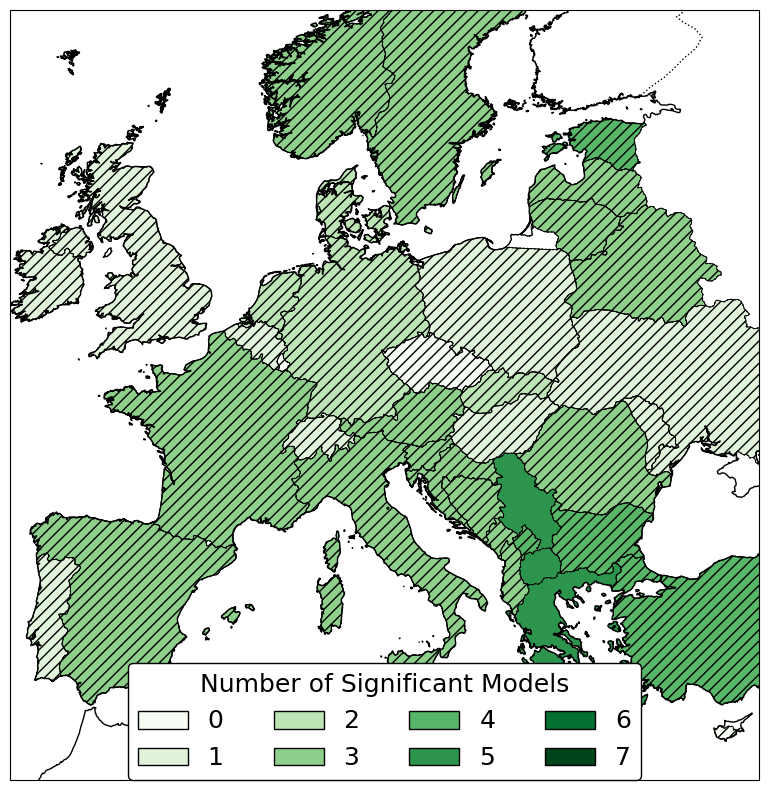

Plot annual p90 results, model agreement.


In [11]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib as mpl

# 1) Read your annual p75‐test results (country in ISO3)
df = pd.read_csv(
    "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/country_annual_p90_tests.csv"
)  # columns: model,country(ISO3),p75_boc,p75_eoc,significant

# 2) Count how many models are significant per ISO3
counts3 = (
    df[df.sig_p90]
      .groupby("country")["model"]
      .nunique()
      .rename("n_models_significant")
      .reset_index()
)

# 3) Build a full list of 3‐letter codes you care about
EU27 = ['AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FRA','DEU','GRC',
        'HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD','POL','PRT','ROU',
        'SVK','SVN','ESP','SWE']
extras = ['GBR','NOR','BIH','MNE','SRB','ALB','MKD','CHE','ISL','TUR','UKR','BLR','MDA','KOS']
all_iso3 = EU27 + extras
summary3 = pd.DataFrame({"ADM0_A3": all_iso3}).merge(
    counts3.rename(columns={"country":"ADM0_A3"}),
    on="ADM0_A3", how="left"
).fillna(0).astype({"n_models_significant":"int"})

# 4) Grab the country shapes keyed by ADM0_A3
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).to_crs("EPSG:4326")

# force Kosovo ISO in NaturalEarth
world.loc[world.ADM0_A3 == "RKS","ADM0_A3"] = "KOS"

eu = world[world.ADM0_A3.isin(all_iso3)][["ADM0_A3","geometry"]]

# 5) Merge on the 3‐letter key
gdf = eu.merge(summary3, on="ADM0_A3", how="left")

# 6) Plot
cmap = plt.get_cmap("Greens", 8)
norm = mpl.colors.BoundaryNorm(range(9), 8)

fig, ax = plt.subplots(
    1,1, figsize=(12,8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
ax.set_extent([-10.5,35,33,64], ccrs.PlateCarree())
ax.coastlines("10m"); ax.add_feature(cfeature.BORDERS, linestyle=":")

gdf.plot(
    column="n_models_significant",
    cmap=cmap, norm=norm,
    linewidth=0.5, edgecolor="black",
    ax=ax,
    missing_kwds={"color":"lightgrey"}
)
low = gdf[gdf.n_models_significant < 5]
low.plot(
    facecolor="none", edgecolor="black",
    hatch="///", linewidth=0.5,
    ax=ax, zorder=3
)
lat0 = (33 + 64) / 2.0
ax.set_aspect(1.0 / np.cos(np.deg2rad(lat0)))


patches = [
    mpatches.Patch(
        facecolor=cmap(i/7),
        edgecolor='black',
        label=f"{i}")
    for i in range(8)
]
ax.legend(
    handles=patches,
    title="Number of Significant Models",
    loc="lower center",
    bbox_to_anchor=(0.5,0.),
    borderaxespad=0., frameon=True,
    edgecolor='black',ncols=4, fontsize=18, title_fontsize=18, framealpha = 1
)

plt.tight_layout()
plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/agreement_P90_year_boc_eoc.pdf", bbox_inches='tight', dpi=300)
plt.show()
print("Plot annual p90 results, model agreement.")


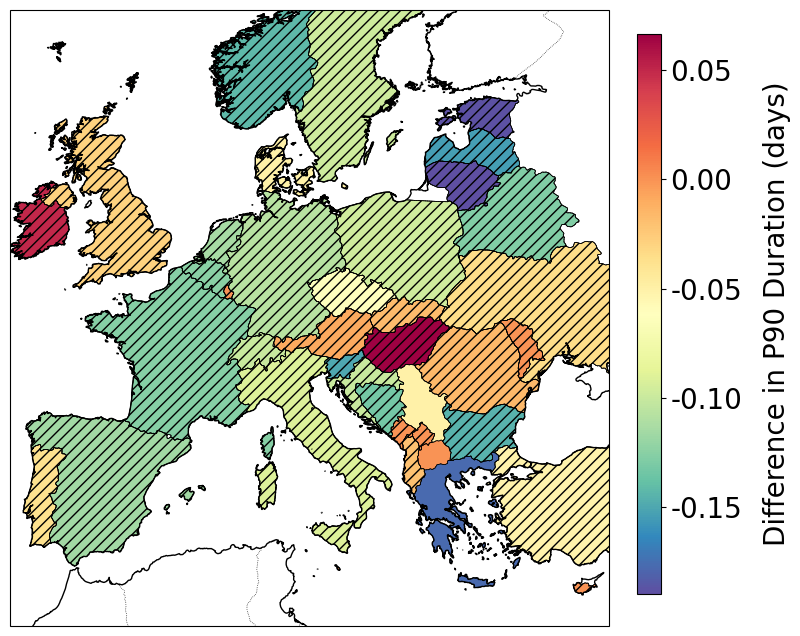

In [10]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl

# 1) Load your annual p75‐test CSV
base_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
csv_path = os.path.join(base_dir, "country_annual_p90_tests.csv")
df = pd.read_csv(csv_path)
# df columns: model, country (ISO3), p75_boc, p75_eoc, shapiro_boc, shapiro_eoc, ttest_p, significant

# 2) Compute per‐country metrics (3‐letter ISO keys)
# 2a) median difference in p75
df["diff"] = df["median_p90_eoc"] - df["median_p90_boc"]
med_diff = (
    df.groupby("country")["diff"]
      .median()
      .rename("median_diff")
      .reset_index()
)

# 2b) number of models flagged significant
counts3 = (
    df[df.sig_p90]
      .groupby("country")["model"]
      .nunique()
      .rename("n_models_significant")
      .reset_index()
)

# 3) Full list of ISO3 codes
EU27   = ['AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FRA','DEU','GRC',
          'HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD','POL','PRT','ROU',
          'SVK','SVN','ESP','SWE']
extras = ['GBR','NOR','BIH','MNE','SRB','ALB','MKD','CHE','ISL','TUR','UKR','BLR','MDA','KOS']
all_iso3 = EU27 + extras

# 4) Assemble summary3 with both metrics
summary3 = pd.DataFrame({"ADM0_A3": all_iso3})\
    .merge(med_diff.rename(columns={"country":"ADM0_A3"}), on="ADM0_A3", how="left")\
    .merge(counts3.rename(columns={"country":"ADM0_A3"}), on="ADM0_A3", how="left")\
    .fillna({"median_diff":0.0, "n_models_significant":0})\
    .astype({"n_models_significant":"int"})

# 5) Load Natural Earth & extract only our region
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).set_crs("EPSG:4326")
# fix Kosovo code
world.loc[world.ADM0_A3 == "RKS", "ADM0_A3"] = "KOS"
eu = world[world.ADM0_A3.isin(all_iso3)][["ADM0_A3","geometry"]]

# 6) Merge geometries + summary3
gdf = eu.merge(summary3, on="ADM0_A3", how="left")

# 7) Build colormap clipped at 5–95% of median_diff
vmin = gdf["median_diff"].min()
vmax = gdf["median_diff"].max()
#norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("Spectral_r")
#cmap = plt.get_cmap("coolwarm")

# 8) Plot
fig, ax = plt.subplots(
    1, 1,
    figsize=(12, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
ax.set_extent([-10.5, 35, 33, 64], ccrs.PlateCarree())
ax.coastlines("10m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)

# main choropleth
gdf.plot(
    column="median_diff",
    cmap=cmap, norm=norm,
    linewidth=0.5, edgecolor="black",
    ax=ax,
    missing_kwds={"color":"lightgrey"}
)

# hatch countries with < 5 agreeing models
low = gdf[gdf.n_models_significant < 5]
low.plot(
    facecolor="none", edgecolor="black",
    hatch="///", linewidth=0.5,
    ax=ax, zorder=3
)

lat0 = (33+64)/2
ax.set_aspect(1/np.cos(np.deg2rad(lat0)))

# 9) Colorbar to the right, outside map
# push whole map a bit left
plt.subplots_adjust(right=0.85)

cax = fig.add_axes([0.76, 0.15, 0.02, 0.7])
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, cax=cax)

cbar.ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.2f"))
cbar.ax.tick_params(labelsize=20)

cbar.set_label("Difference in P90 Duration (days)", fontsize=20, labelpad=15)
plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/p90_diff_boc_eoc_boc_eoc.pdf", bbox_inches='tight', dpi=300)
plt.show()

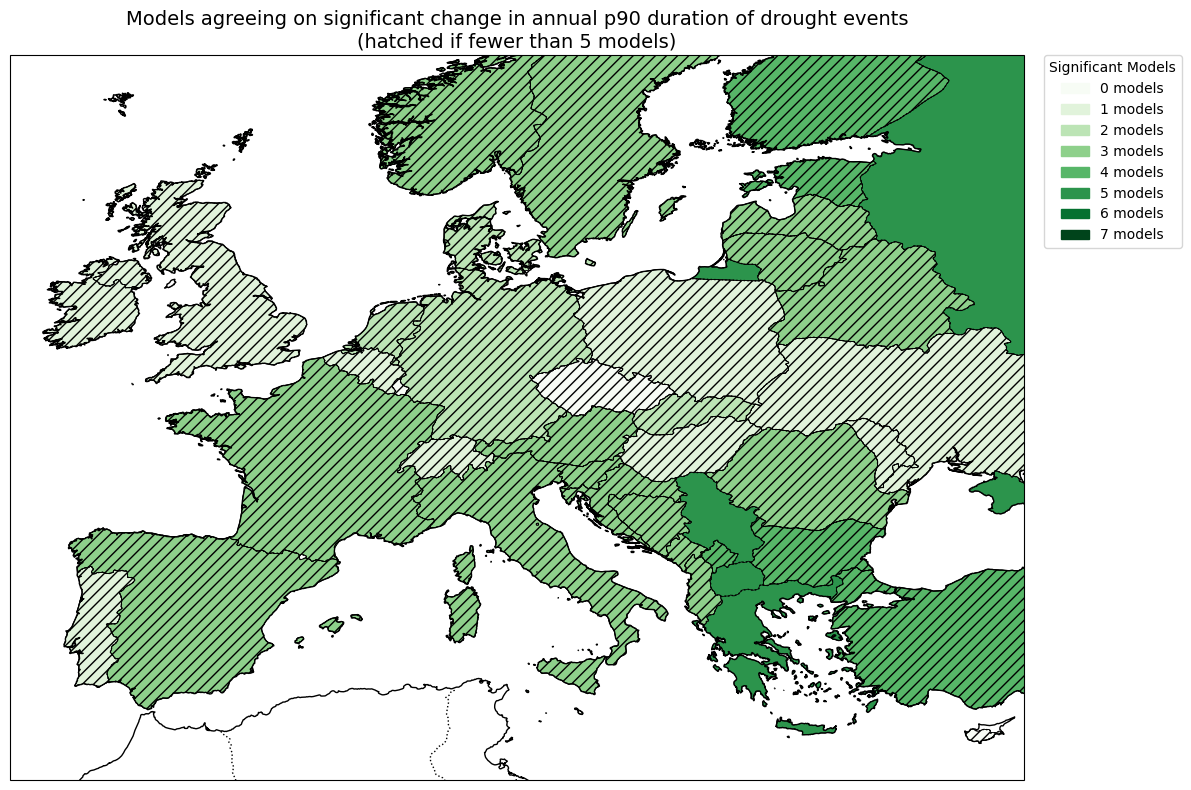

Plot annual p90 results, model agreement.


In [40]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib as mpl

# 1) Read your annual p75‐test results (country in ISO3)
df = pd.read_csv(
    "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/country_annual_p90_tests.csv"
)  # columns: model,country(ISO3),p75_boc,p75_eoc,significant

# 2) Count how many models are significant per ISO3
counts3 = (
    df[df.sig_p90]
      .groupby("country")["model"]
      .nunique()
      .rename("n_models_significant")
      .reset_index()
)

# 3) Build a full list of 3‐letter codes you care about
EU27 = ['AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FIN','FRA','DEU','GRC',
        'HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD','POL','PRT','ROU',
        'SVK','SVN','ESP','SWE']
extras = ['GBR','NOR','BIH','MNE','SRB','ALB','MKD','CHE','ISL','TUR','UKR','BLR','MDA','RUS','KOS']
all_iso3 = EU27 + extras
summary3 = pd.DataFrame({"ADM0_A3": all_iso3}).merge(
    counts3.rename(columns={"country":"ADM0_A3"}),
    on="ADM0_A3", how="left"
).fillna(0).astype({"n_models_significant":"int"})

# 4) Grab the country shapes keyed by ADM0_A3
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).to_crs("EPSG:4326")

# force Kosovo ISO in NaturalEarth
world.loc[world.ADM0_A3 == "RKS","ADM0_A3"] = "KOS"

eu = world[world.ADM0_A3.isin(all_iso3)][["ADM0_A3","geometry"]]

# 5) Merge on the 3‐letter key
gdf = eu.merge(summary3, on="ADM0_A3", how="left")

# 6) Plot
cmap = plt.get_cmap("Greens", 8)
norm = mpl.colors.BoundaryNorm(range(9), 8)

fig, ax = plt.subplots(
    1,1, figsize=(12,8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
ax.set_extent([-12,35,33,64], ccrs.PlateCarree())
ax.coastlines("10m"); ax.add_feature(cfeature.BORDERS, linestyle=":")

gdf.plot(
    column="n_models_significant",
    cmap=cmap, norm=norm,
    linewidth=0.5, edgecolor="black",
    ax=ax,
    missing_kwds={"color":"lightgrey"}
)
low = gdf[gdf.n_models_significant < 5]
low.plot(
    facecolor="none", edgecolor="black",
    hatch="///", linewidth=0.5,
    ax=ax, zorder=3
)
ax.set_aspect('auto')

ax.set_title("Models agreeing on significant change in annual p90 duration of drought events\n(hatched if fewer than 5 models)", fontsize=14)

patches = [
    mpatches.Patch(color=cmap(i/7), label=f"{i} models")
    for i in range(8)
]
ax.legend(
    handles=patches,
    title="Significant Models",
    loc="upper left",
    bbox_to_anchor=(1.02,1),
    borderaxespad=0.
)

plt.tight_layout()
plt.show()
print("Plot annual p90 results, model agreement.")

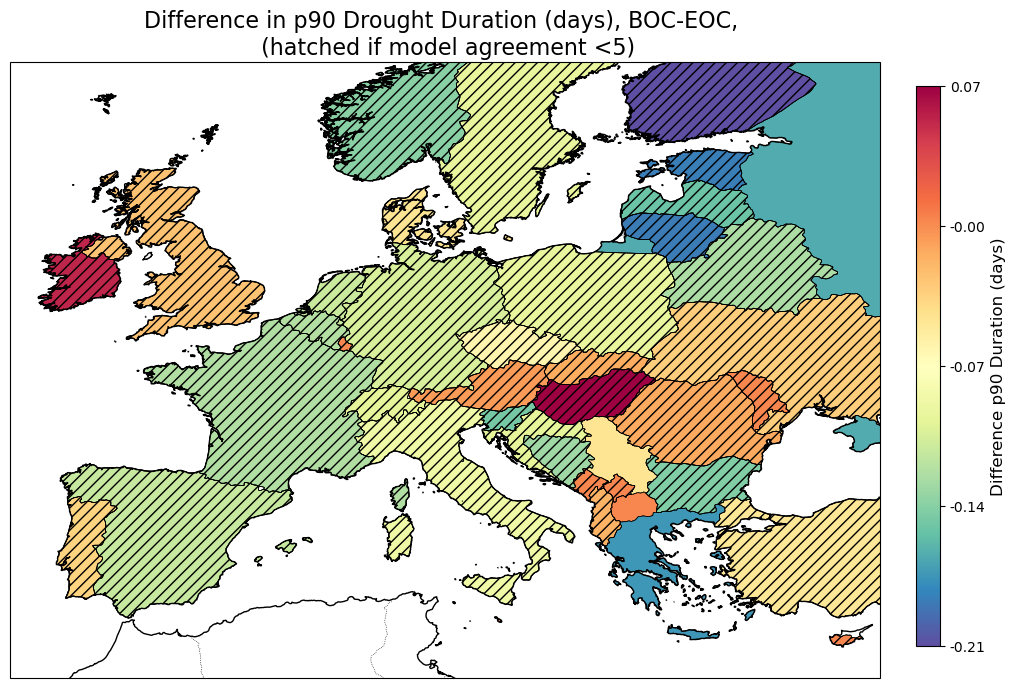

plot annual p75 difference


In [42]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl

# 1) Load your annual p75‐test CSV
base_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power"
csv_path = os.path.join(base_dir, "country_annual_p90_tests.csv")
df = pd.read_csv(csv_path)
# df columns: model, country (ISO3), p75_boc, p75_eoc, shapiro_boc, shapiro_eoc, ttest_p, significant

# 2) Compute per‐country metrics (3‐letter ISO keys)
# 2a) median difference in p75
df["diff"] = df["median_p90_eoc"] - df["median_p90_boc"]
med_diff = (
    df.groupby("country")["diff"]
      .median()
      .rename("median_diff")
      .reset_index()
)

# 2b) number of models flagged significant
counts3 = (
    df[df.sig_p90]
      .groupby("country")["model"]
      .nunique()
      .rename("n_models_significant")
      .reset_index()
)

# 3) Full list of ISO3 codes
EU27   = ['AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FIN','FRA','DEU','GRC',
          'HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD','POL','PRT','ROU',
          'SVK','SVN','ESP','SWE']
extras = ['GBR','NOR','BIH','MNE','SRB','ALB','MKD','CHE','ISL','TUR','UKR','BLR','MDA','RUS','KOS']
all_iso3 = EU27 + extras

# 4) Assemble summary3 with both metrics
summary3 = pd.DataFrame({"ADM0_A3": all_iso3})\
    .merge(med_diff.rename(columns={"country":"ADM0_A3"}), on="ADM0_A3", how="left")\
    .merge(counts3.rename(columns={"country":"ADM0_A3"}), on="ADM0_A3", how="left")\
    .fillna({"median_diff":0.0, "n_models_significant":0})\
    .astype({"n_models_significant":"int"})

# 5) Load Natural Earth & extract only our region
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).set_crs("EPSG:4326")
# fix Kosovo code
world.loc[world.ADM0_A3 == "RKS", "ADM0_A3"] = "KOS"
eu = world[world.ADM0_A3.isin(all_iso3)][["ADM0_A3","geometry"]]

# 6) Merge geometries + summary3
gdf = eu.merge(summary3, on="ADM0_A3", how="left")

# 7) Build colormap clipped at 5–95% of median_diff
vmin = gdf["median_diff"].min()
vmax = gdf["median_diff"].max()
#norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("Spectral_r")
#cmap = plt.get_cmap("coolwarm")

# 8) Plot
fig, ax = plt.subplots(
    1, 1,
    figsize=(12, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
ax.set_extent([-12, 35, 33, 64], ccrs.PlateCarree())
ax.coastlines("10m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)

# main choropleth
gdf.plot(
    column="median_diff",
    cmap=cmap, norm=norm,
    linewidth=0.5, edgecolor="black",
    ax=ax,
    missing_kwds={"color":"lightgrey"}
)

# hatch countries with < 5 agreeing models
low = gdf[gdf.n_models_significant < 5]
low.plot(
    facecolor="none", edgecolor="black",
    hatch="///", linewidth=0.5,
    ax=ax, zorder=3
)

ax.set_aspect("auto")
ax.set_title("Difference in p90 Drought Duration (days), BOC-EOC, \n (hatched if model agreement <5)", fontsize=16)

# 9) Colorbar to the right, outside map
# push whole map a bit left
plt.subplots_adjust(right=0.85)

cax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
# explicitly set & format ticks
ticks = np.linspace(norm.vmin, norm.vmax, 5)
cbar.set_ticks(ticks)
cbar.ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.2f"))
cbar.ax.tick_params(labelsize=10)

cbar.set_label("Difference p90 Duration (days)", fontsize=12)

plt.show()
print("plot annual p75 difference")

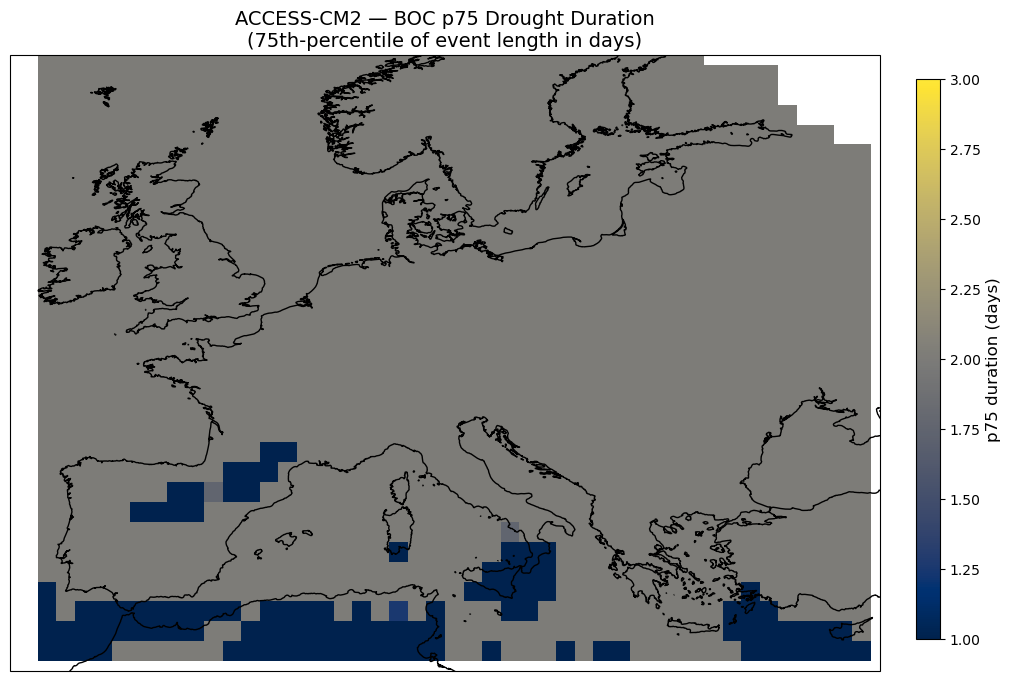

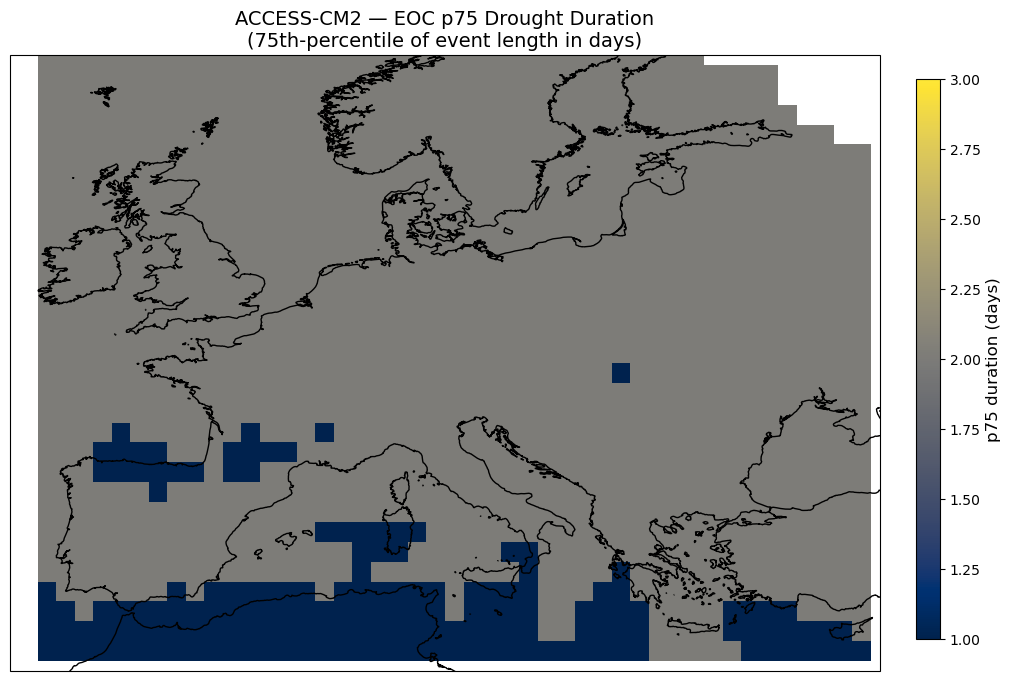

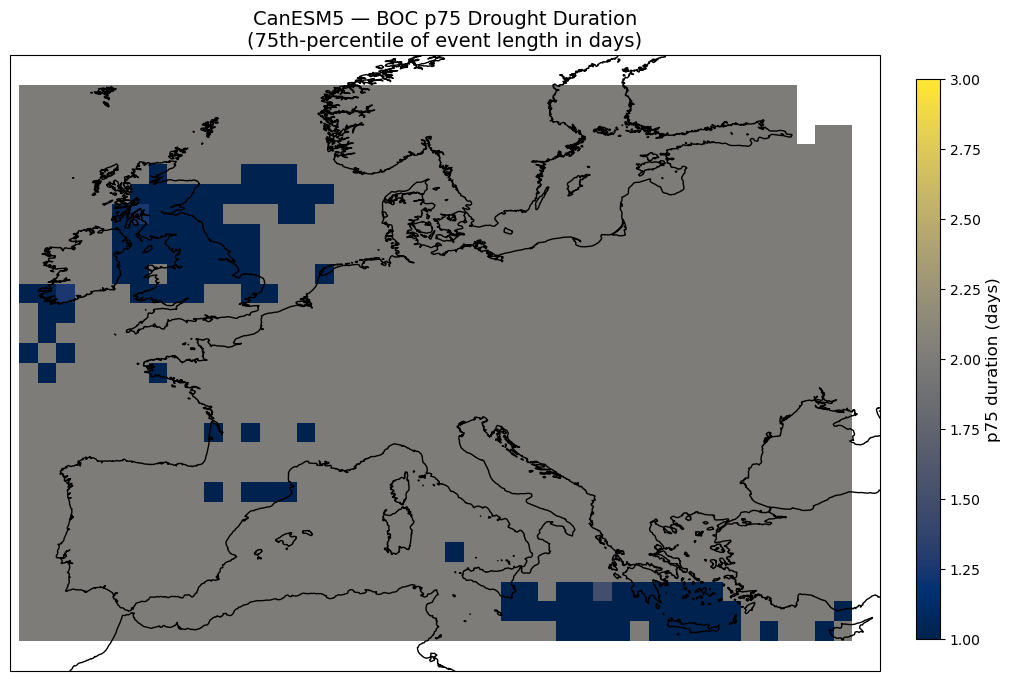

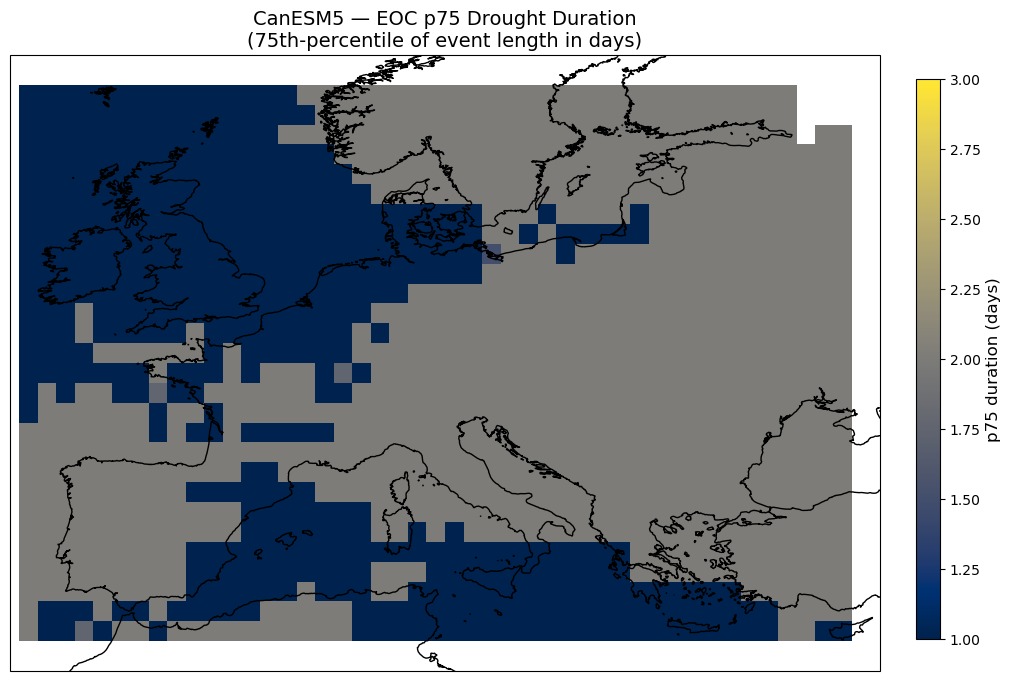

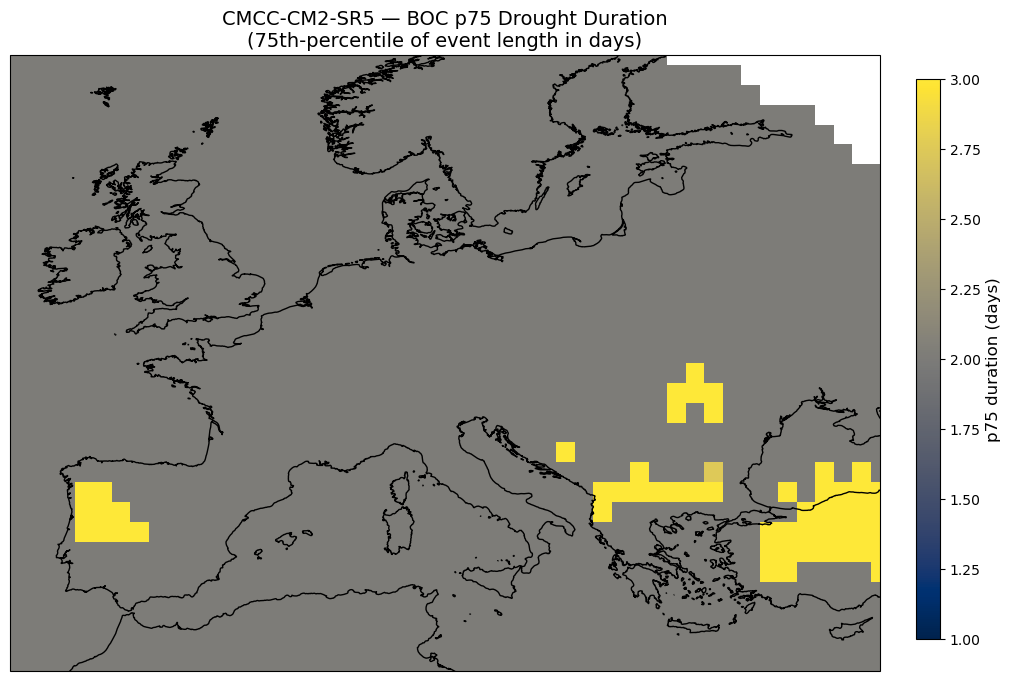

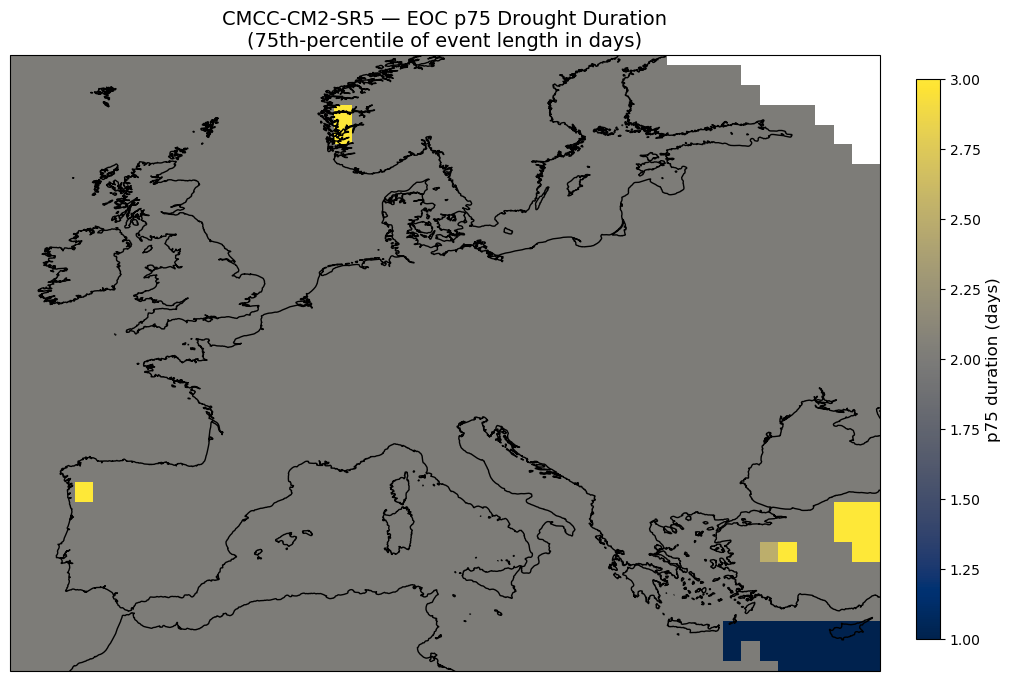

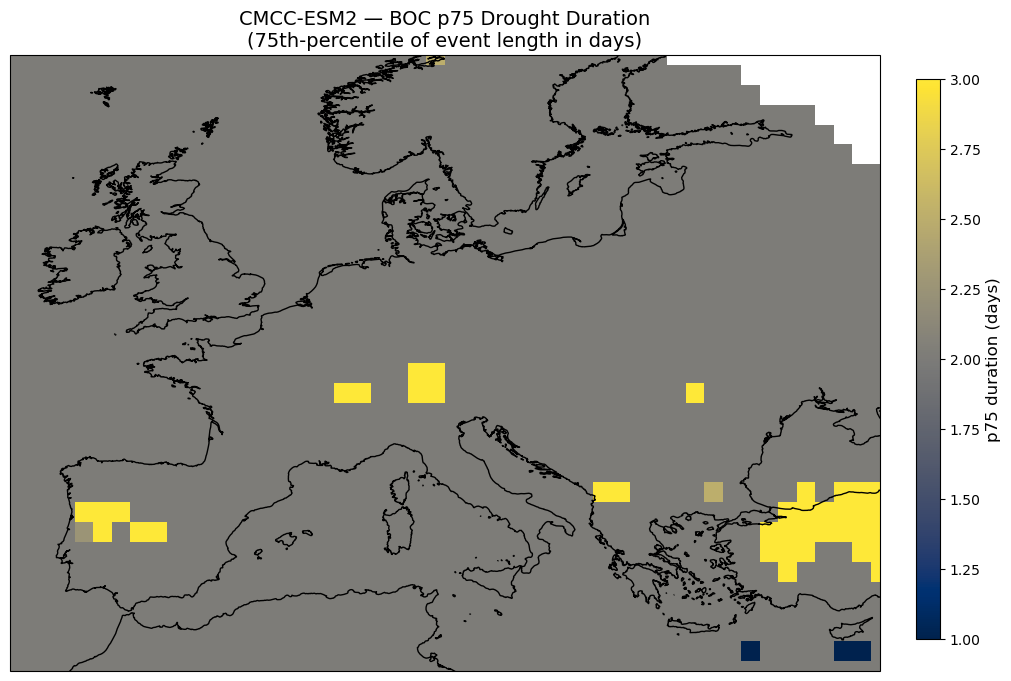

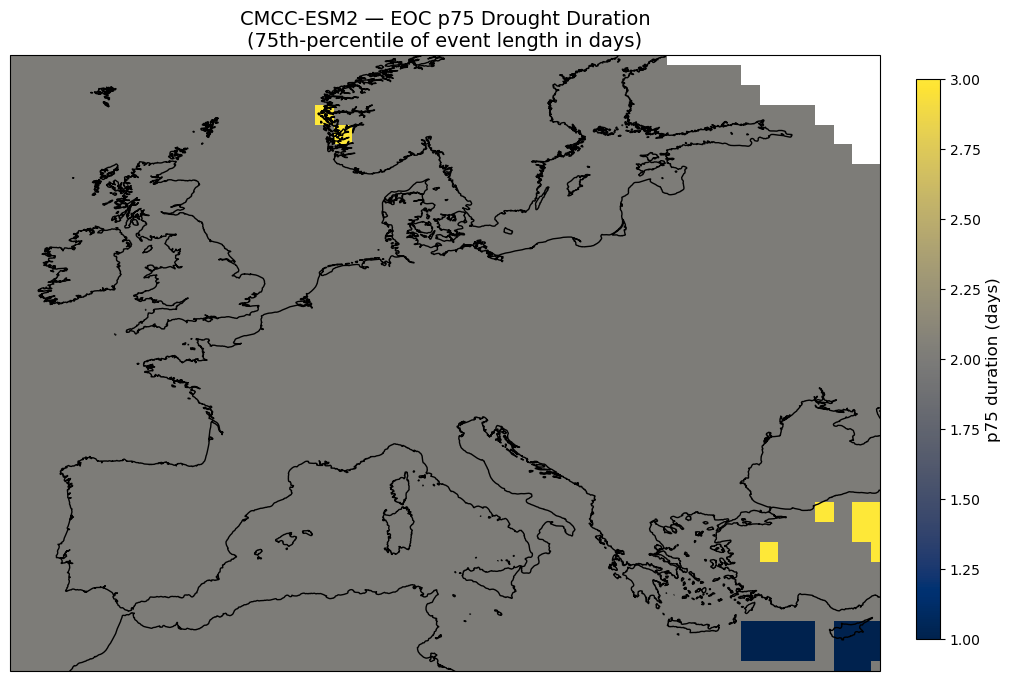

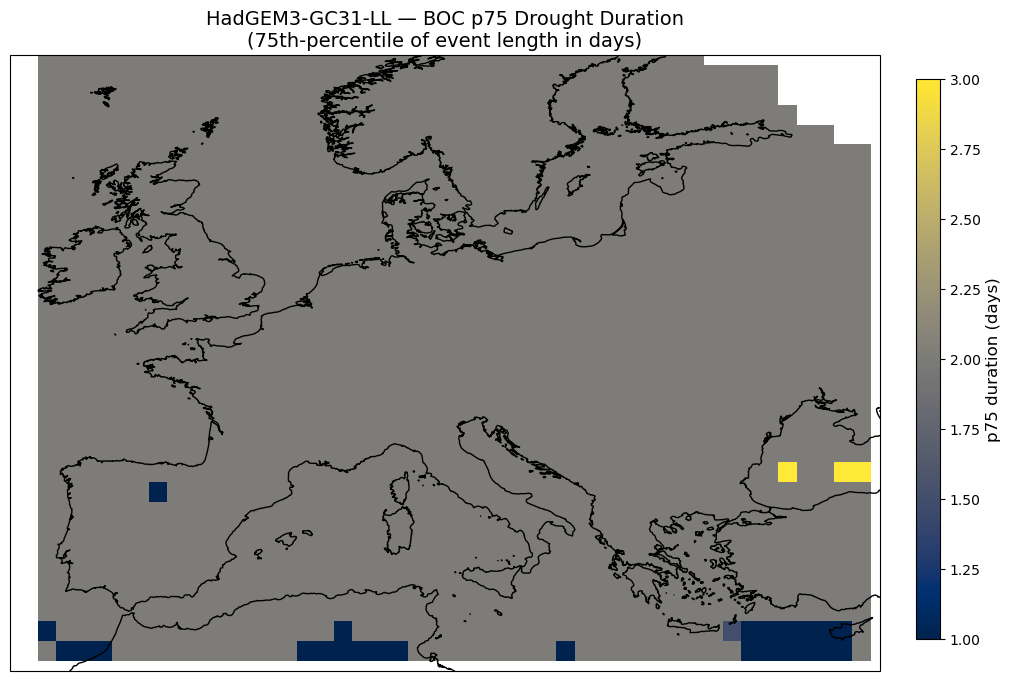

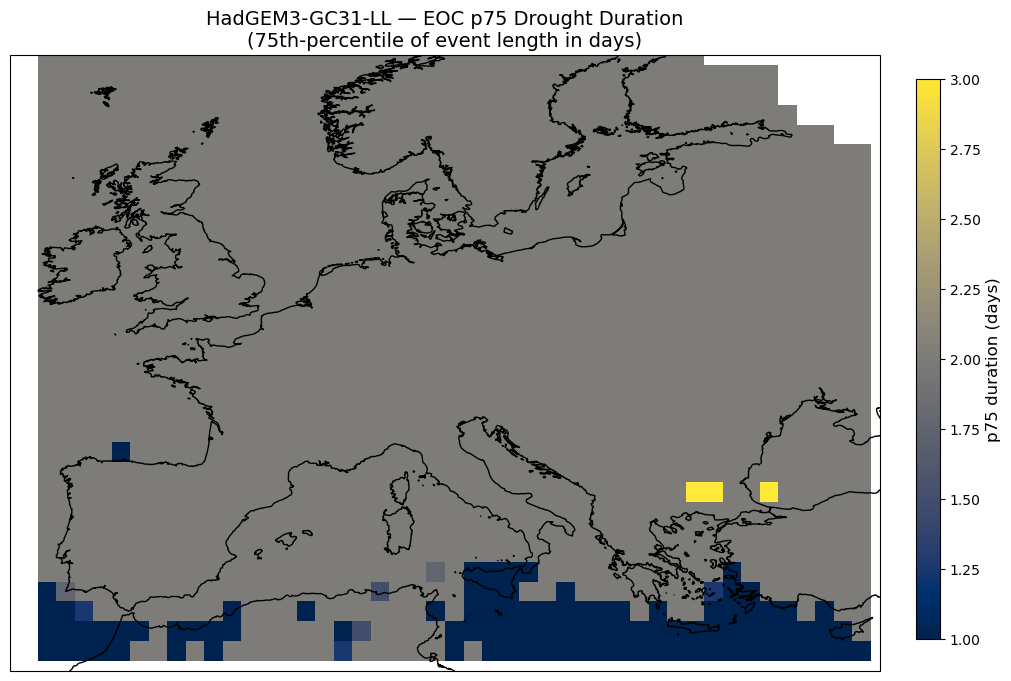

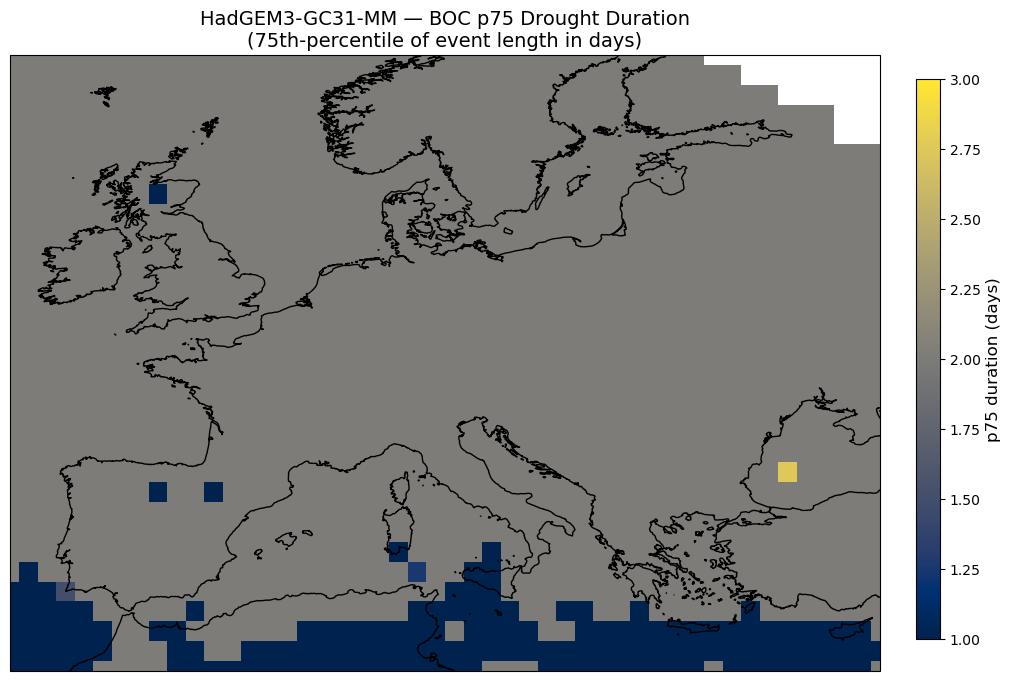

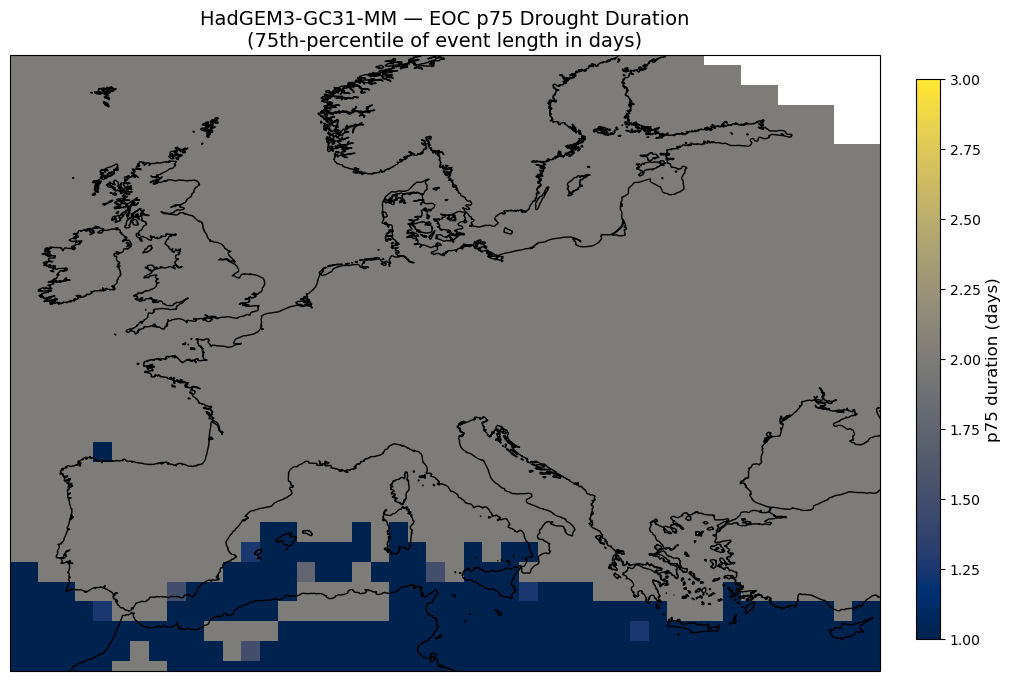

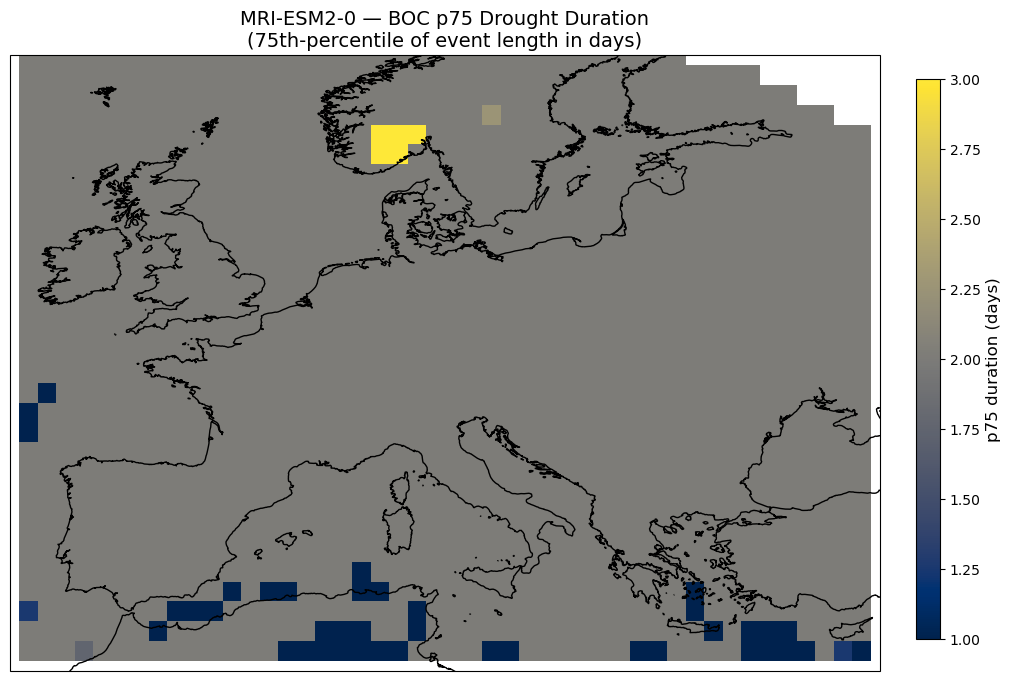

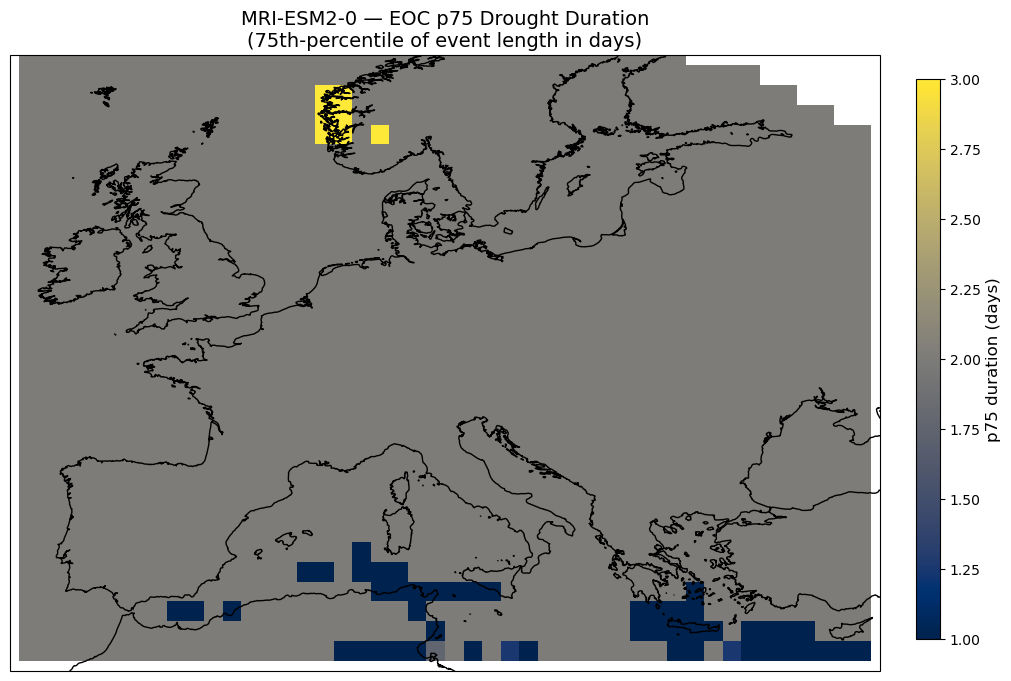

In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# ─── CONFIG ────────────────────────────────────────────────────────────
power_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power"
models    = ["ACCESS-CM2","CanESM5","CMCC-CM2-SR5","CMCC-ESM2",
             "HadGEM3-GC31-LL","HadGEM3-GC31-MM","MRI-ESM2-0"]
periods   = {"BOC":"historical","EOC":"ssp585"}

# 1) First pass: gather every cell’s p75 to get a common vmin/vmax
all_p75 = []
for model in models:
    for code, sub in periods.items():
        path = os.path.join(power_dir, f"{model}_1x1grid", sub,
                            f"solar_drought_events_{code}.csv")
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path)
        # group by cell and take the 75th percentile of duration
        p75 = df.groupby(["lat","lon"])["duration"].quantile(0.75)
        all_p75.append(p75.values)

if not all_p75:
    raise RuntimeError("No event CSVs found!")

all_p75 = np.concatenate(all_p75)
vmin, vmax = np.nanmin(all_p75), np.nanmax(all_p75)

# choose a gentle, perceptually uniform cmap
cmap = plt.get_cmap("cividis")

# 2) Second pass: plot each model×period with the shared scale
for model in models:
    for code, sub in periods.items():
        csv_path = os.path.join(
            power_dir, f"{model}_1x1grid", sub,
            f"solar_drought_events_{code}.csv"
        )
        if not os.path.exists(csv_path):
            print(f"❌ Missing {csv_path}, skipping")
            continue

        df = pd.read_csv(csv_path)
        # compute p75 per cell
        p75 = (
            df.groupby(["lat","lon"])["duration"]
              .quantile(0.75)
              .reset_index(name="p75_duration")
        )

        # prepare grid
        lats = np.sort(p75.lat.unique())
        lons = np.sort(p75.lon.unique())
        grid = (
            p75
            .pivot(index="lat", columns="lon", values="p75_duration")
            .reindex(index=lats, columns=lons)
            .values
        )

        # plot
        fig, ax = plt.subplots(
            figsize=(12,8),
            subplot_kw={"projection": ccrs.PlateCarree()}
        )
        ax.set_extent([-12,35,33,64], ccrs.PlateCarree())
        mesh = ax.pcolormesh(
            lons, lats, grid,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            vmin=vmin, vmax=vmax,
            shading="auto"
        )
        ax.coastlines("10m", linewidth=1)
        ax.set_aspect("auto")
        ax.set_title(
            f"{model} — {code} p75 Drought Duration\n"
            f"(75th-percentile of event length in days)",
            fontsize=14
        )

        # push map left, colorbar on the right
        plt.subplots_adjust(right=0.85)
        cax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
        cbar = plt.colorbar(mesh, cax=cax)
        cbar.set_label("p75 duration (days)", fontsize=12)
        cbar.ax.tick_params(labelsize=10)

        plt.show()


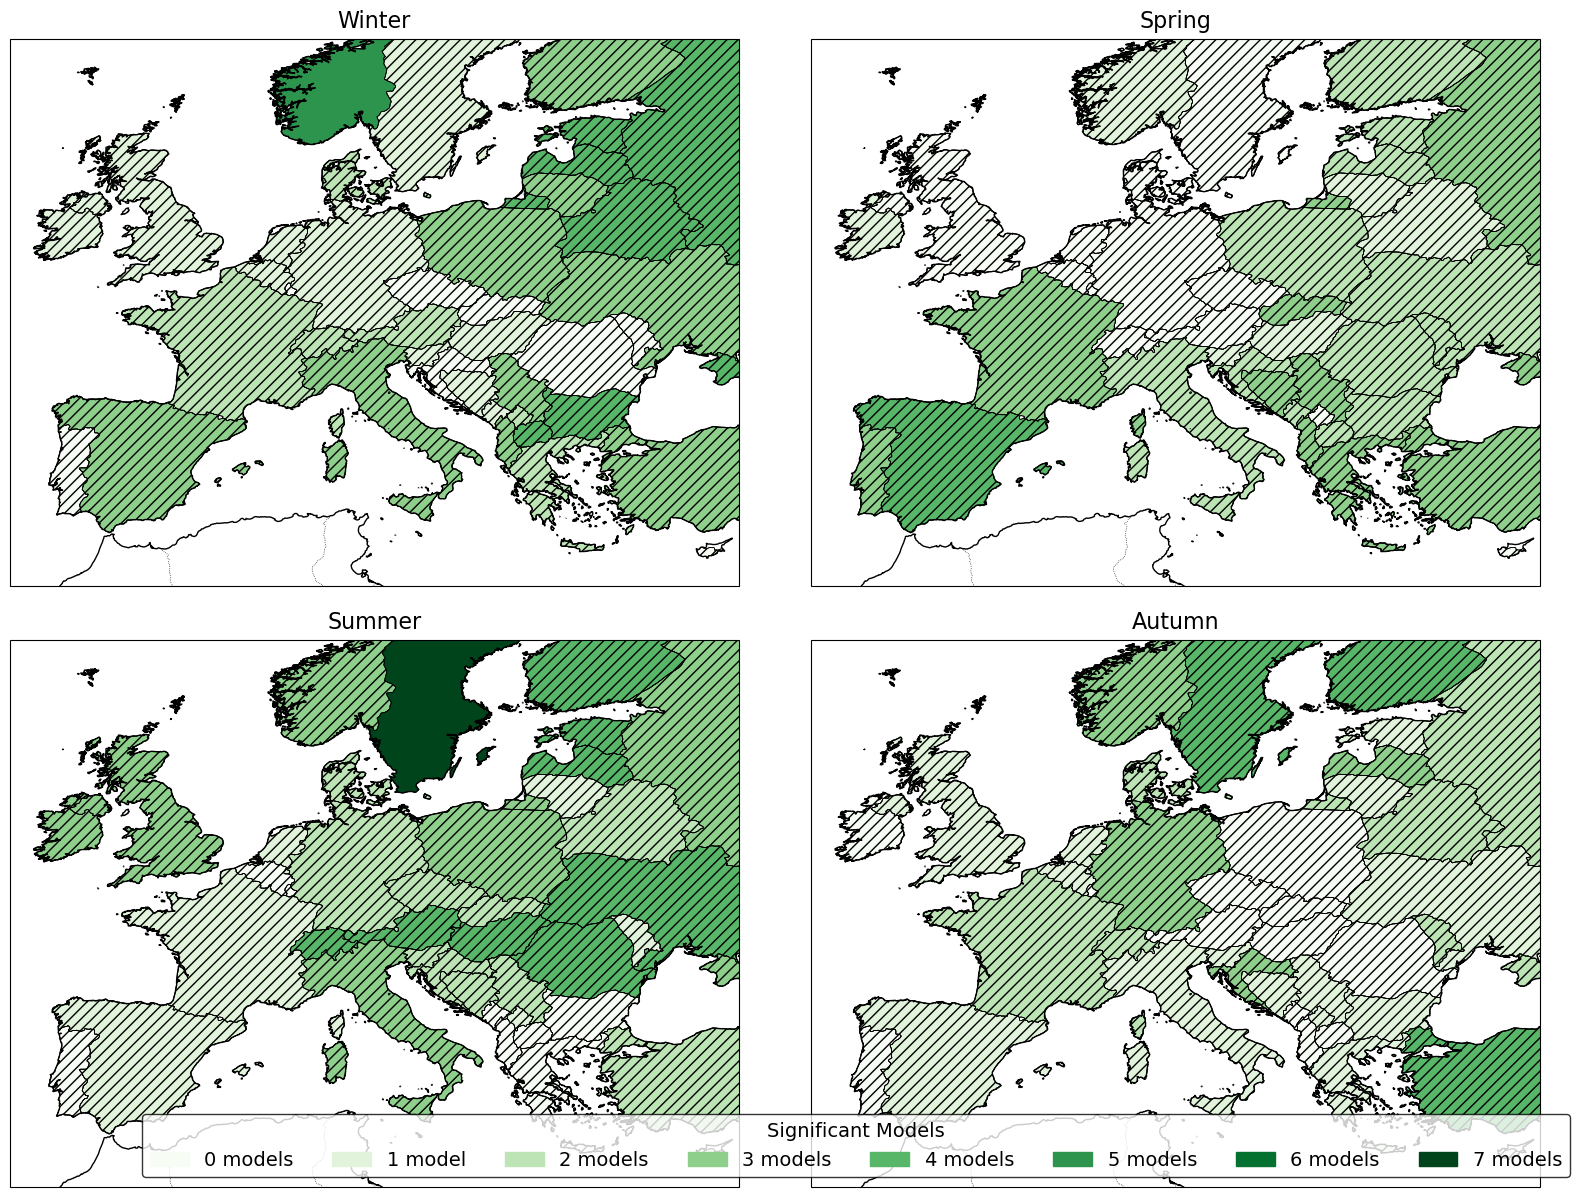

plot seasonal p75 results, model agreement.


In [ ]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pycountry
import matplotlib.patches as mpatches

# ─── 1) Load your seasonal p75‐test results ────────────────────────────
# CSV must have columns: model, country (ISO3), season, significant (bool)
csv_path = os.path.join(
    "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power",
    "country_seasonal_p75_tests.csv"
)
df = pd.read_csv(csv_path)

# ─── 2) Map ISO-3 → ISO-2 (incl. KOS→XK, MKD→MK) ────────────────────────
def iso3_to_iso2(iso3):
    if iso3 == 'KOS': return 'XK'
    if iso3 == 'MKD': return 'MK'
    try:
        return pycountry.countries.get(alpha_3=iso3).alpha_2
    except:
        return None

df['ISO_A2'] = df['country'].map(iso3_to_iso2)
df = df.dropna(subset=['ISO_A2'])

# ─── 3) Build per-country×season summary of “# significant models” ──────
seasons = ['Winter','Spring','Summer','Autumn']
EU27   = ['AT','BE','BG','HR','CZ','DK','EE','FI','FR','DE','GR',
          'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
          'SK','SI','ES','SE','CY']
extras = ['GB','NO','BA','ME','RS','AL','MK','CH','IS','TR','UA','BY','MD','RU','XK']
all_codes = EU27 + extras

# count unique models per ISO2+season
summary = (
    df[df['significant']]
      .groupby(['ISO_A2','season'])['model']
      .nunique()
      .rename('n_models_significant')
      .reset_index()
)

# ensure every country×season appears
full = pd.MultiIndex.from_product([all_codes, seasons], names=['ISO_A2','season'])
summary = (
    summary.set_index(['ISO_A2','season'])
           .reindex(full, fill_value=0)
           .reset_index()
)

# ─── 4) Load Natural Earth & force‐map two‐letter codes ───────────────
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).to_crs("EPSG:4326")
# correct a few names
world.loc[world.NAME_LONG=='France',             'ISO_A2'] = 'FR'
world.loc[world.NAME_LONG=='Russian Federation', 'ISO_A2'] = 'RU'
world.loc[world.NAME_LONG=='United Kingdom',     'ISO_A2'] = 'GB'
world.loc[world.NAME_LONG=='Norway',             'ISO_A2'] = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosov'), 'ISO_A2'] = 'XK'

# restrict to our region
eu = world[world['ISO_A2'].isin(all_codes)][['ISO_A2','geometry']].copy()

# ─── 5) Colormap setup ─────────────────────────────────────────────────
maxm = summary['n_models_significant'].max()  # at most 7
cmap = plt.get_cmap('Greens', maxm+1)
norm = mpl.colors.BoundaryNorm(np.arange(maxm+2)-0.5, maxm+1)

# ─── 6) Build 2×2 seasonal panel ───────────────────────────────────────
fig, axes = plt.subplots(
    2, 2,
    figsize=(18, 14),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=False
)

for ax, season in zip(axes.flat, seasons):
    # merge counts for this season
    df_seas = summary[summary['season']==season][['ISO_A2','n_models_significant']]
    gdf = eu.merge(df_seas, on='ISO_A2', how='left')
    gdf['n_models_significant'] = gdf['n_models_significant'].fillna(0).astype(int)

    # main fill
    gdf.plot(
        column='n_models_significant',
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor='black',
        ax=ax,
        missing_kwds={'color':'lightgrey'}
    )

    # hatched where <5 models agree
    low = gdf[gdf['n_models_significant'] < 5]
    low.plot(
        facecolor='none', edgecolor='black',
        hatch='///', linewidth=0.5,
        ax=ax, zorder=3
    )

    ax.coastlines('10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_extent([-12, 35, 33, 64], ccrs.PlateCarree())
    ax.set_aspect('auto')
    ax.set_title(season, fontsize=16, pad=8)

# ─── 7) Final layout, title, and shared legend ─────────────────────────
fig.subplots_adjust(
    left=0.03, right=0.88,
    top=0.90, bottom=0.08,
    wspace=0.10, hspace=0.10
)


patches = [
    mpatches.Patch(color=cmap(i), label=f"{i} model{'s' if i!=1 else ''}")
    for i in range(maxm+1)
]
fig.legend(
    handles=patches,
    title="Significant Models",
    loc='lower center',
    ncol=8,
    fontsize=14,
    title_fontsize=14,
    frameon=True,
    edgecolor='black',
    bbox_to_anchor=(0.45, 0.08)
)

plt.savefig("test.pdf", bbox_inches='tight', dpi=300)
plt.show()
print("plot seasonal p75 results, model agreement.")


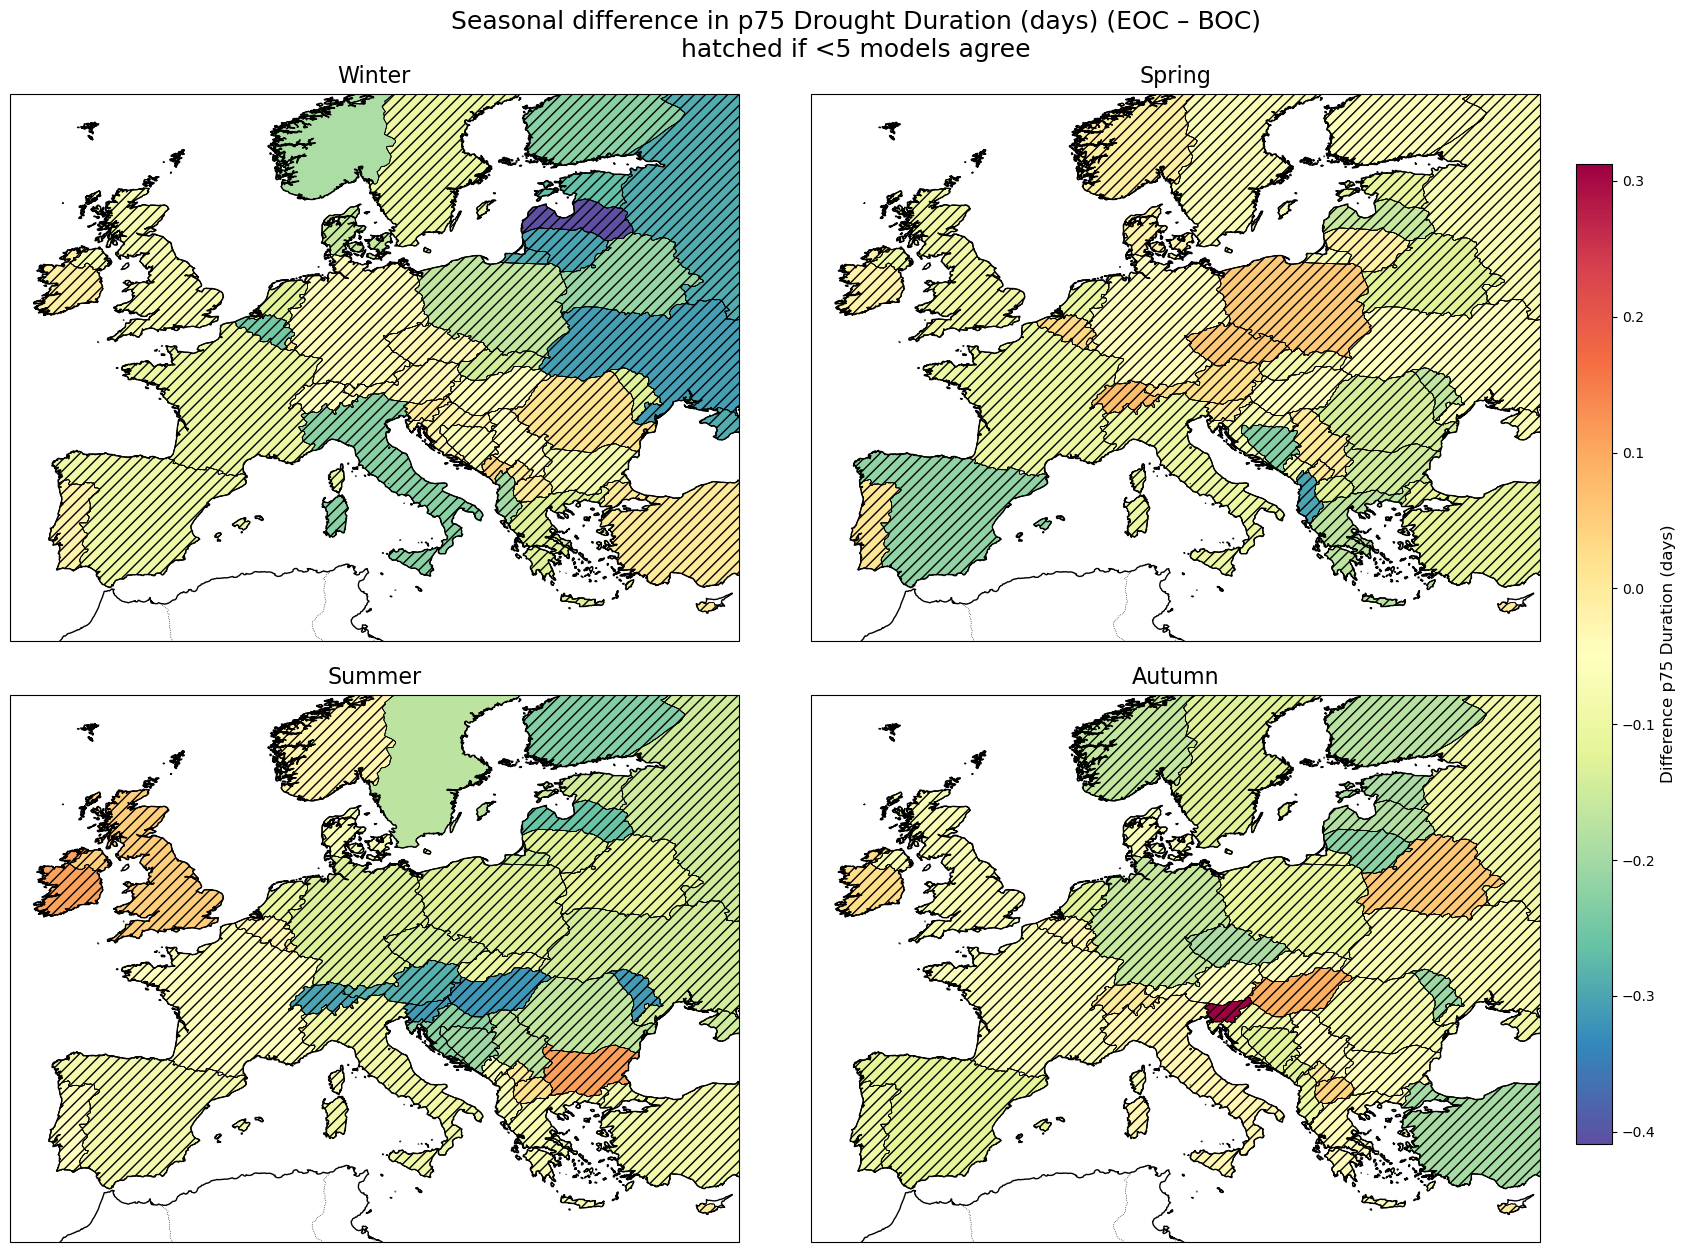

plot seasonal p75 difference


In [ ]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pycountry
import matplotlib.patches as mpatches

# ─── 1) Load your seasonal p75‐test results ────────────────────────────
# CSV must have columns: model, country (ISO3), season, p75_boc, p75_eoc, significant
base_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
csv_path = os.path.join(base_dir, "country_seasonal_p75_tests.csv")
df = pd.read_csv(csv_path)

# ─── 2) Compute per‐country×season metrics ─────────────────────────────
# a) Δp75
df["diff"] = df["p75_eoc"] - df["p75_boc"]

# b) median Δp75 per country+season
med_diff = (
    df.groupby(["country","season"])["diff"]
      .median()
      .rename("median_diff")
      .reset_index()
)

# c) count how many models flagged significant per country+season
counts = (
    df[df["significant"]]
      .groupby(["country","season"])["model"]
      .nunique()
      .rename("n_models_significant")
      .reset_index()
)

# ─── 3) Ensure every country+season appears ────────────────────────────
# full lists
EU27   = ['AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FIN','FRA','DEU','GRC',
          'HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD','POL','PRT','ROU',
          'SVK','SVN','ESP','SWE']
extras = ['GBR','NOR','BIH','MNE','SRB','ALB','MKD','CHE','ISL','TUR','UKR','BLR','MDA','RUS','KOS']
all_iso3   = EU27 + extras
seasons    = ["Winter","Spring","Summer","Autumn"]

# cartesian product to fill zeros
idx = pd.MultiIndex.from_product([all_iso3, seasons], names=["country","season"])
summary = (
    pd.concat([med_diff.set_index(["country","season"]),
               counts.set_index(["country","season"])],
              axis=1)
      .reindex(idx, fill_value=0)
      .reset_index()
)

# ─── 4) Load Natural Earth & fix ISO3→ADM0_A3 ─────────────────────────
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).set_crs("EPSG:4326")
# Natural Earth uses RKS for Kosovo
world.loc[world.ADM0_A3=="RKS","ADM0_A3"] = "KOS"

# take only our countries
eu = world[world.ADM0_A3.isin(all_iso3)][["ADM0_A3","geometry"]].copy()

# ─── 5) Merge geometries + our summary ────────────────────────────────
# we'll do this per-season when plotting

# ─── 6) Colormap setup ───────────────────────────────────────────────
vmin = summary["median_diff"].min()
vmax = summary["median_diff"].max()
cmap = plt.get_cmap("Spectral_r")
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# ─── 7) Draw 2×2 panel of Δp75 ───────────────────────────────────────
fig, axes = plt.subplots(
    2, 2, figsize=(18,14),
    subplot_kw={"projection": ccrs.PlateCarree()},
    constrained_layout=False
)

for ax, season in zip(axes.flat, seasons):
    # merge this season
    df_seas = summary[summary["season"]==season]
    gdf = eu.merge(df_seas,
                   left_on="ADM0_A3", right_on="country",
                   how="left")
    gdf["n_models_significant"] = gdf["n_models_significant"].fillna(0).astype(int)
    gdf["median_diff"] = gdf["median_diff"].fillna(0.0)

    # choropleth
    gdf.plot(
        column="median_diff",
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor="black",
        ax=ax,
        missing_kwds={"color":"lightgrey"}
    )
    # hatch where <5 models agree
    low = gdf[gdf["n_models_significant"]<5]
    low.plot(
        facecolor="none", edgecolor="black",
        hatch="///", linewidth=0.5,
        ax=ax, zorder=3
    )

    ax.coastlines("10m", linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
    ax.set_extent([-12,35,33,64], ccrs.PlateCarree())
    ax.set_aspect("auto")
    ax.set_title(season, fontsize=18, pad=8)

# ─── 8) Final title & colorbar ───────────────────────────────────────
fig.subplots_adjust(left=0.03, right=0.88, top=0.90, bottom=0.08,
                    wspace=0.10, hspace=0.10)


# shared colorbar to the right
cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Difference p75 Duration (days)", fontsize=18)
cbar.ax.tick_params(labelsize=10)

plt.show()
print("plot seasonal p75 difference")
